<a href="https://colab.research.google.com/github/kassemm/assignment1/blob/master/GermanTrafficSignsNew.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle
!pip install --user kaggle

In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "./"

In [3]:
#Download data from kaggle 
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
!kaggle trainsets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

 98% 601M/612M [00:10<00:00, 30.0MB/s]
100% 612M/612M [00:10<00:00, 62.2MB/s]
usage: kaggle [-h] [-v] {competitions,c,datasets,d,kernels,k,config} ...
kaggle: error: argument command: invalid choice: 'trainsets' (choose from 'competitions', 'c', 'datasets', 'd', 'kernels', 'k', 'config')


In [ ]:
#After getting the data from kaggle unzipping the zip files and deleting the zip files
!unzip \*.zip

In [5]:
# Few imports
#from google.colab import drive
#drive.mount('/gdrive')

import torch
import torchvision
from torchvision import transforms
import torch.utils.data as data
import torch.optim as optim
import torch.nn as nn
from torchsummary import summary
import time
import numpy as np
import os
import matplotlib.pyplot as plt

from PIL import Image
import random

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [6]:
# Before starting, clear the memory

torch.cuda.empty_cache()

In [7]:
# Define the transformations. To begin with, we shall keep it minimum - only resizing the images and converting them to PyTorch tensors

data_transforms = transforms.Compose([
    transforms.Resize([112, 112]), ##resize 
    transforms.ToTensor()  ##image to pytoch 
    ])

In [8]:
# Defining hyperparameters

BATCH_SIZE = 256;
learning_rate = 0.001;
EPOCHS = 50;
numClasses = 43; ##number of classes to be classified


In [9]:
from torch.utils.data import Dataset
import natsort as natsort;



# Define path of training data

train_data_path = "./Train"
test_data_path = "./Test"


train_data = torchvision.datasets.ImageFolder(root = train_data_path, transform = data_transforms)


# Divide data into training and validation (0.8 and 0.2)
ratio = 0.8
n_train_examples = int(len(train_data) * ratio)
n_val_examples = len(train_data) - n_train_examples

train_data, val_data = data.random_split(train_data, [n_train_examples, n_val_examples])

print(f"Number of training samples = {len(train_data)}")
print(f"Number of validation samples = {len(val_data)}")
#print(f"Number of test samples = {len(test_data)}")



Number of training samples = 31367
Number of validation samples = 7842


In [10]:
#from google.colab import drive
#drive.mount('/content/drive')

In [42]:
#Create my own custom dataset to handle test data 
import pandas as pd;
col_list = ["Width","Height","Roi.X1","Roi.Y1","Roi.X2","Roi.Y2","ClassId","Path"]
df = pd.read_csv("./Test.csv", usecols=col_list)

##Custom data set function to load the images from the test dir.
class CustomDataSet(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsort.natsorted(all_imgs)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image

    #function created to return all the images of the test set.
    
    def __returnImagesClass__(self):
      datasetImages=[];

      classId=df["ClassId"].to_list()

      for i in range(0,self.__len__() -1 ): # take only images
        datasetImages.append(test_set.__getitem__(i));
      
      #datasetImages: array with all the images
      #classId: array with all the classID(name of the folder) of all images in the test set
      datasetClass=[datasetImages,classId]
      return datasetClass



In [43]:
#Here I load test data to test_data_array
## test_data_arry[0]  --> #images
# test_data_arry[1]  --> #immageClassId

test_data_dir = "./Test"


test_data_transforms = transforms.Compose([
    transforms.Resize([112, 112]), ##resize
    transforms.ToTensor()  ##image to torch
    ])

test_set = CustomDataSet(test_data_dir, transform=test_data_transforms)

test_data_arry=[];

classId=df["ClassId"].to_list()
pathImage=df["Path"].to_list()

#in test_data_arry will have all images in test + their classID
test_data_arry=test_set.__returnImagesClass__();


#print("test_data set =",test_set.__len__())
#print(test_set.__getitem__(0))


print(f"Number of training samples = {len(train_data)}")
print(f"Number of validation samples = {len(val_data)}")
print(f"Number of test samples = {len(test_data_arry[0])}")

Number of training samples = 31367
Number of validation samples = 7842
Number of test samples = 12630


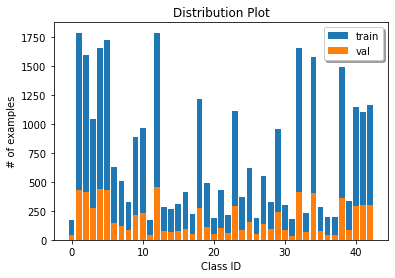

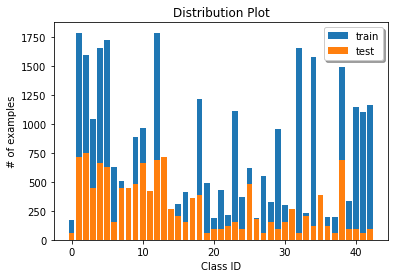

In [13]:
# Plot histogram for training, test and validation data
#Visualizing data

train_hist = [0]*numClasses
for i in train_data.indices:
    tar = train_data.dataset.targets[i]
    train_hist[tar] += 1

val_hist = [0]*numClasses


for i in val_data.indices:
    tar = val_data.dataset.targets[i]
    val_hist[tar] += 1



test_hist = [0]*numClasses

for i in range(0,len(test_data_arry[1])):
    tar = test_data_arry[1][i]
    test_hist[tar] += 1



plt.bar(range(numClasses), train_hist, label="train")
plt.bar(range(numClasses), val_hist, label="val")


legend = plt.legend(loc='upper right', shadow=True)
plt.title("Distribution Plot")
plt.xlabel("Class ID")
plt.ylabel("# of examples")

plt.savefig("train_val_split.png", bbox_inches = 'tight', pad_inches=0.5)

plt.figure(0)
###
plt.bar(range(numClasses), train_hist, label="train")
plt.bar(range(numClasses), test_hist, label="test")


legend = plt.legend(loc='upper right', shadow=True)
plt.title("Distribution Plot")
plt.xlabel("Class ID")
plt.ylabel("# of examples")

plt.savefig("train_test_split.png", bbox_inches = 'tight', pad_inches=0.5)

In [45]:
# Create data loader for training and validation

train_loader = data.DataLoader(train_data, shuffle=True, batch_size = BATCH_SIZE)
val_loader = data.DataLoader(val_data, shuffle=True, batch_size = BATCH_SIZE)

#future work -> to create a loader for the test data like train data instead of manually looping through the test_data_arry
#test_loader =data.DataLoader(test_set,shuffle=True,batch_size=BATCH_SIZE)



In [46]:
# Function to count the number of parameters in the model

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [16]:
#How to calculate the input to the cnn
#notes The number of output channels corresponds to the number of convolution filters/kernels you want this layer to have.
#For details explanation on how to calculate these numbers refer to this link 
#https://medium.datadriveninvestor.com/architecture-implementation-of-lenet-from-scratch-in-pytorch-709cc38c00a9

#Example for the first layer in AlexnetTS
#out of conv2d  = (112 +2*1 -3 )/ +1 = 56
#number of output channels depends on the filters 

import torch
batch_size=1  #from the data_loader  112*112 image size, 3 RGB.
input_images = torch.rand(batch_size, 3, 112, 112) # N(batch size), C(channels), H, W
conv = torch.nn.Conv2d(
		in_channels=3, # RGB channels
		out_channels=64, # Number of kernels (filters)
		kernel_size=3, # Size of kernels, i. e. of size 5x5
		stride=2,
		padding=1)
print(conv.weight.size()) # 64 x 3 x 3 x 3 (64 kernels of size 5x5 having 3 of depth) 7 filters of size 3*3 
print(conv(input_images).size()) 



torch.Size([64, 3, 3, 3])
torch.Size([1, 64, 56, 56])


In [47]:
#notes The number of output channels corresponds to the number of convolution filters/kernels you want this layer to have.
#For details explanation on how to calculate these numbers refer to this link 
#https://medium.datadriveninvestor.com/architecture-implementation-of-lenet-from-scratch-in-pytorch-709cc38c00a9

#out of conv2d  = (112 +2*1 -3 )/ +1 = 56
#number of output channels depends on the filters 
import torch.nn as nn

class AlexnetTS(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=64, out_channels=192, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),
            )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256*7*7, 1000),  ## from the output of last conv network nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Dropout(0.5),
            nn.Linear(in_features=1000, out_features=256),
            nn.ReLU(inplace=True),
            
            nn.Linear(256, output_dim)
            )
        
    def forward(self, x):
        x = self.features(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

In [48]:
# Initialize the model
# The model is defined in the class AlexnetTS in the file class_alexnetTS.py

#from class_alexnetTS import AlexnetTS
model = AlexnetTS(numClasses)
print(f'The model has {count_parameters(model):,} trainable parameters')


The model has 15,063,891 trainable parameters


In [49]:
# Define optimizer and criterion functions loss function

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()


In [50]:
# If CUDA is available, convert model and loss to cuda variables

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

In [51]:
print(model)
print(summary(model, (3, 112, 112)))


AlexnetTS(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=12544, out_features=1000, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5,

In [52]:
# Print model's state dict

print("Model's state dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
print("")


Model's state dict:
features.0.weight 	 torch.Size([64, 3, 3, 3])
features.0.bias 	 torch.Size([64])
features.3.weight 	 torch.Size([192, 64, 3, 3])
features.3.bias 	 torch.Size([192])
features.6.weight 	 torch.Size([384, 192, 3, 3])
features.6.bias 	 torch.Size([384])
features.8.weight 	 torch.Size([256, 384, 3, 3])
features.8.bias 	 torch.Size([256])
features.10.weight 	 torch.Size([256, 256, 3, 3])
features.10.bias 	 torch.Size([256])
classifier.1.weight 	 torch.Size([1000, 12544])
classifier.1.bias 	 torch.Size([1000])
classifier.4.weight 	 torch.Size([256, 1000])
classifier.4.bias 	 torch.Size([256])
classifier.6.weight 	 torch.Size([43, 256])
classifier.6.bias 	 torch.Size([43])



In [53]:
# Print optimizer details

print("Optimizer details:")
print(optimizer)
print("")


Optimizer details:
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)



In [54]:
#Function to calculate the accuracy of the prediction
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc


In [57]:
def train(model, loader, opt, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    # Train the model
    model.train()
    
    for (images, labels) in loader:
        images = images.cuda()
        labels = labels.cuda()
        
        # Training pass
        opt.zero_grad()
        
        output, _ = model(images)
        loss = criterion(output, labels)
        
        # Backpropagation
        loss.backward()
        
        # Calculate accuracy on test data
        acc = calculate_accuracy(output, labels)
        
        # Optimizing weights
        opt.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(loader), epoch_acc / len(loader)


In [58]:
# Function to perform evaluation on the trained model

def evaluate(model, loader, opt, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    # Evaluate the model
    model.eval()
    
    with torch.no_grad():
        for (images, labels) in loader:
            images = images.cuda()
            labels = labels.cuda()
            
            # Run predictions
            output, _ = model(images)
            loss = criterion(output, labels)
            
            # Calculate accuracy
            acc = calculate_accuracy(output, labels)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    
    return epoch_loss / len(loader), epoch_acc / len(loader)


In [59]:
# Perform training

# List to save training and val loss and accuracies
train_loss_list = [0]*EPOCHS
train_acc_list = [0]*EPOCHS
val_loss_list = [0]*EPOCHS
val_acc_list = [0]*EPOCHS

for epoch in range(EPOCHS):
    print("Epoch-%d: " % (epoch))

    train_start_time = time.monotonic()
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    train_end_time = time.monotonic()

    val_start_time = time.monotonic()
    val_loss, val_acc = evaluate(model, val_loader, optimizer, criterion)
    val_end_time = time.monotonic()
    
    train_loss_list[epoch] = train_loss
    train_acc_list[epoch] = train_acc
    val_loss_list[epoch] = val_loss
    val_acc_list[epoch] = val_acc
    
    print("Training: Loss = %.4f, Accuracy = %.4f, Time = %.2f seconds" % (train_loss, train_acc, train_end_time - train_start_time))
    print("Validation: Loss = %.4f, Accuracy = %.4f, Time = %.2f seconds" % (val_loss, val_acc, val_end_time - val_start_time))
    print("")

Epoch-0: 
Training: Loss = 3.5015, Accuracy = 0.0753, Time = 25.42 seconds
Validation: Loss = 3.2702, Accuracy = 0.1122, Time = 5.43 seconds

Epoch-1: 
Training: Loss = 2.7515, Accuracy = 0.2021, Time = 25.15 seconds
Validation: Loss = 1.7141, Accuracy = 0.4295, Time = 5.32 seconds

Epoch-2: 
Training: Loss = 1.4295, Accuracy = 0.5108, Time = 24.87 seconds
Validation: Loss = 0.9508, Accuracy = 0.6684, Time = 5.30 seconds

Epoch-3: 
Training: Loss = 0.7992, Accuracy = 0.7256, Time = 25.09 seconds
Validation: Loss = 0.3169, Accuracy = 0.8970, Time = 5.36 seconds

Epoch-4: 
Training: Loss = 0.3238, Accuracy = 0.8927, Time = 24.87 seconds
Validation: Loss = 0.1594, Accuracy = 0.9513, Time = 5.27 seconds

Epoch-5: 
Training: Loss = 0.1611, Accuracy = 0.9482, Time = 25.22 seconds
Validation: Loss = 0.0610, Accuracy = 0.9828, Time = 5.33 seconds

Epoch-6: 
Training: Loss = 0.1073, Accuracy = 0.9659, Time = 24.87 seconds
Validation: Loss = 0.0534, Accuracy = 0.9829, Time = 5.32 seconds

Epoch-

In [66]:
# Saving the model

# Create folder to save model
MODEL_FOLDER = "."
if not os.path.isdir(MODEL_FOLDER):
    os.mkdir(MODEL_FOLDER)
    
PATH_TO_MODEL = "./pytorch_classification_alexnetTS.pth"
if os.path.exists(PATH_TO_MODEL):
    os.remove(PATH_TO_MODEL)
torch.save(model.state_dict(), PATH_TO_MODEL)

print("Model saved at %s" %(PATH_TO_MODEL))


Model saved at ./pytorch_classification_alexnetTS.pth


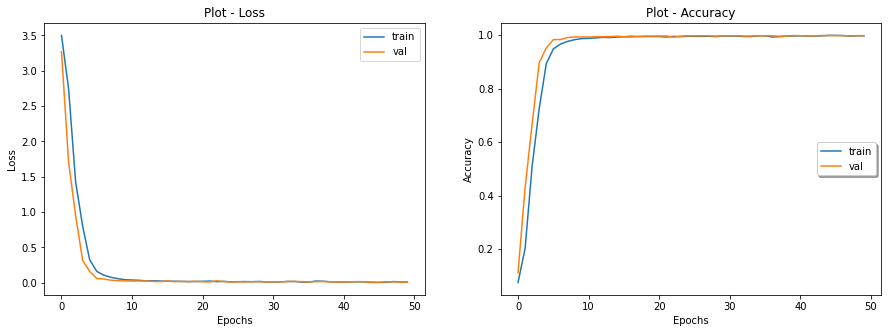

In [67]:
# Plot loss and accuracies for training and validation data

_, axs = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axs[0].plot(train_loss_list, label="train")
axs[0].plot(val_loss_list, label="val")
axs[0].set_title("Plot - Loss")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
legend = axs[0].legend(loc='upper right', shadow=False)

# Accuracy plot
axs[1].plot(train_acc_list, label="train")
axs[1].plot(val_acc_list, label="val")
axs[1].set_title("Plot - Accuracy")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
legend = axs[1].legend(loc='center right', shadow=True)


In [ ]:
print("Load model")

Load model


In [ ]:
#Incase we want to skip training
PATH_TO_MODEL = "./pytorch_classification_alexnetTS.pth"
model = AlexnetTS(numClasses)


# If CUDA is available, convert model and loss to cuda variables

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

model.load_state_dict(torch.load(PATH_TO_MODEL))
model.eval()

print(model)
print(summary(model, (3, 112, 112)))

AlexnetTS(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=12544, out_features=1000, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5,

In [ ]:
print(model)
print(summary(model, (3, 112, 112)))

AlexnetTS(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=12544, out_features=1000, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5,

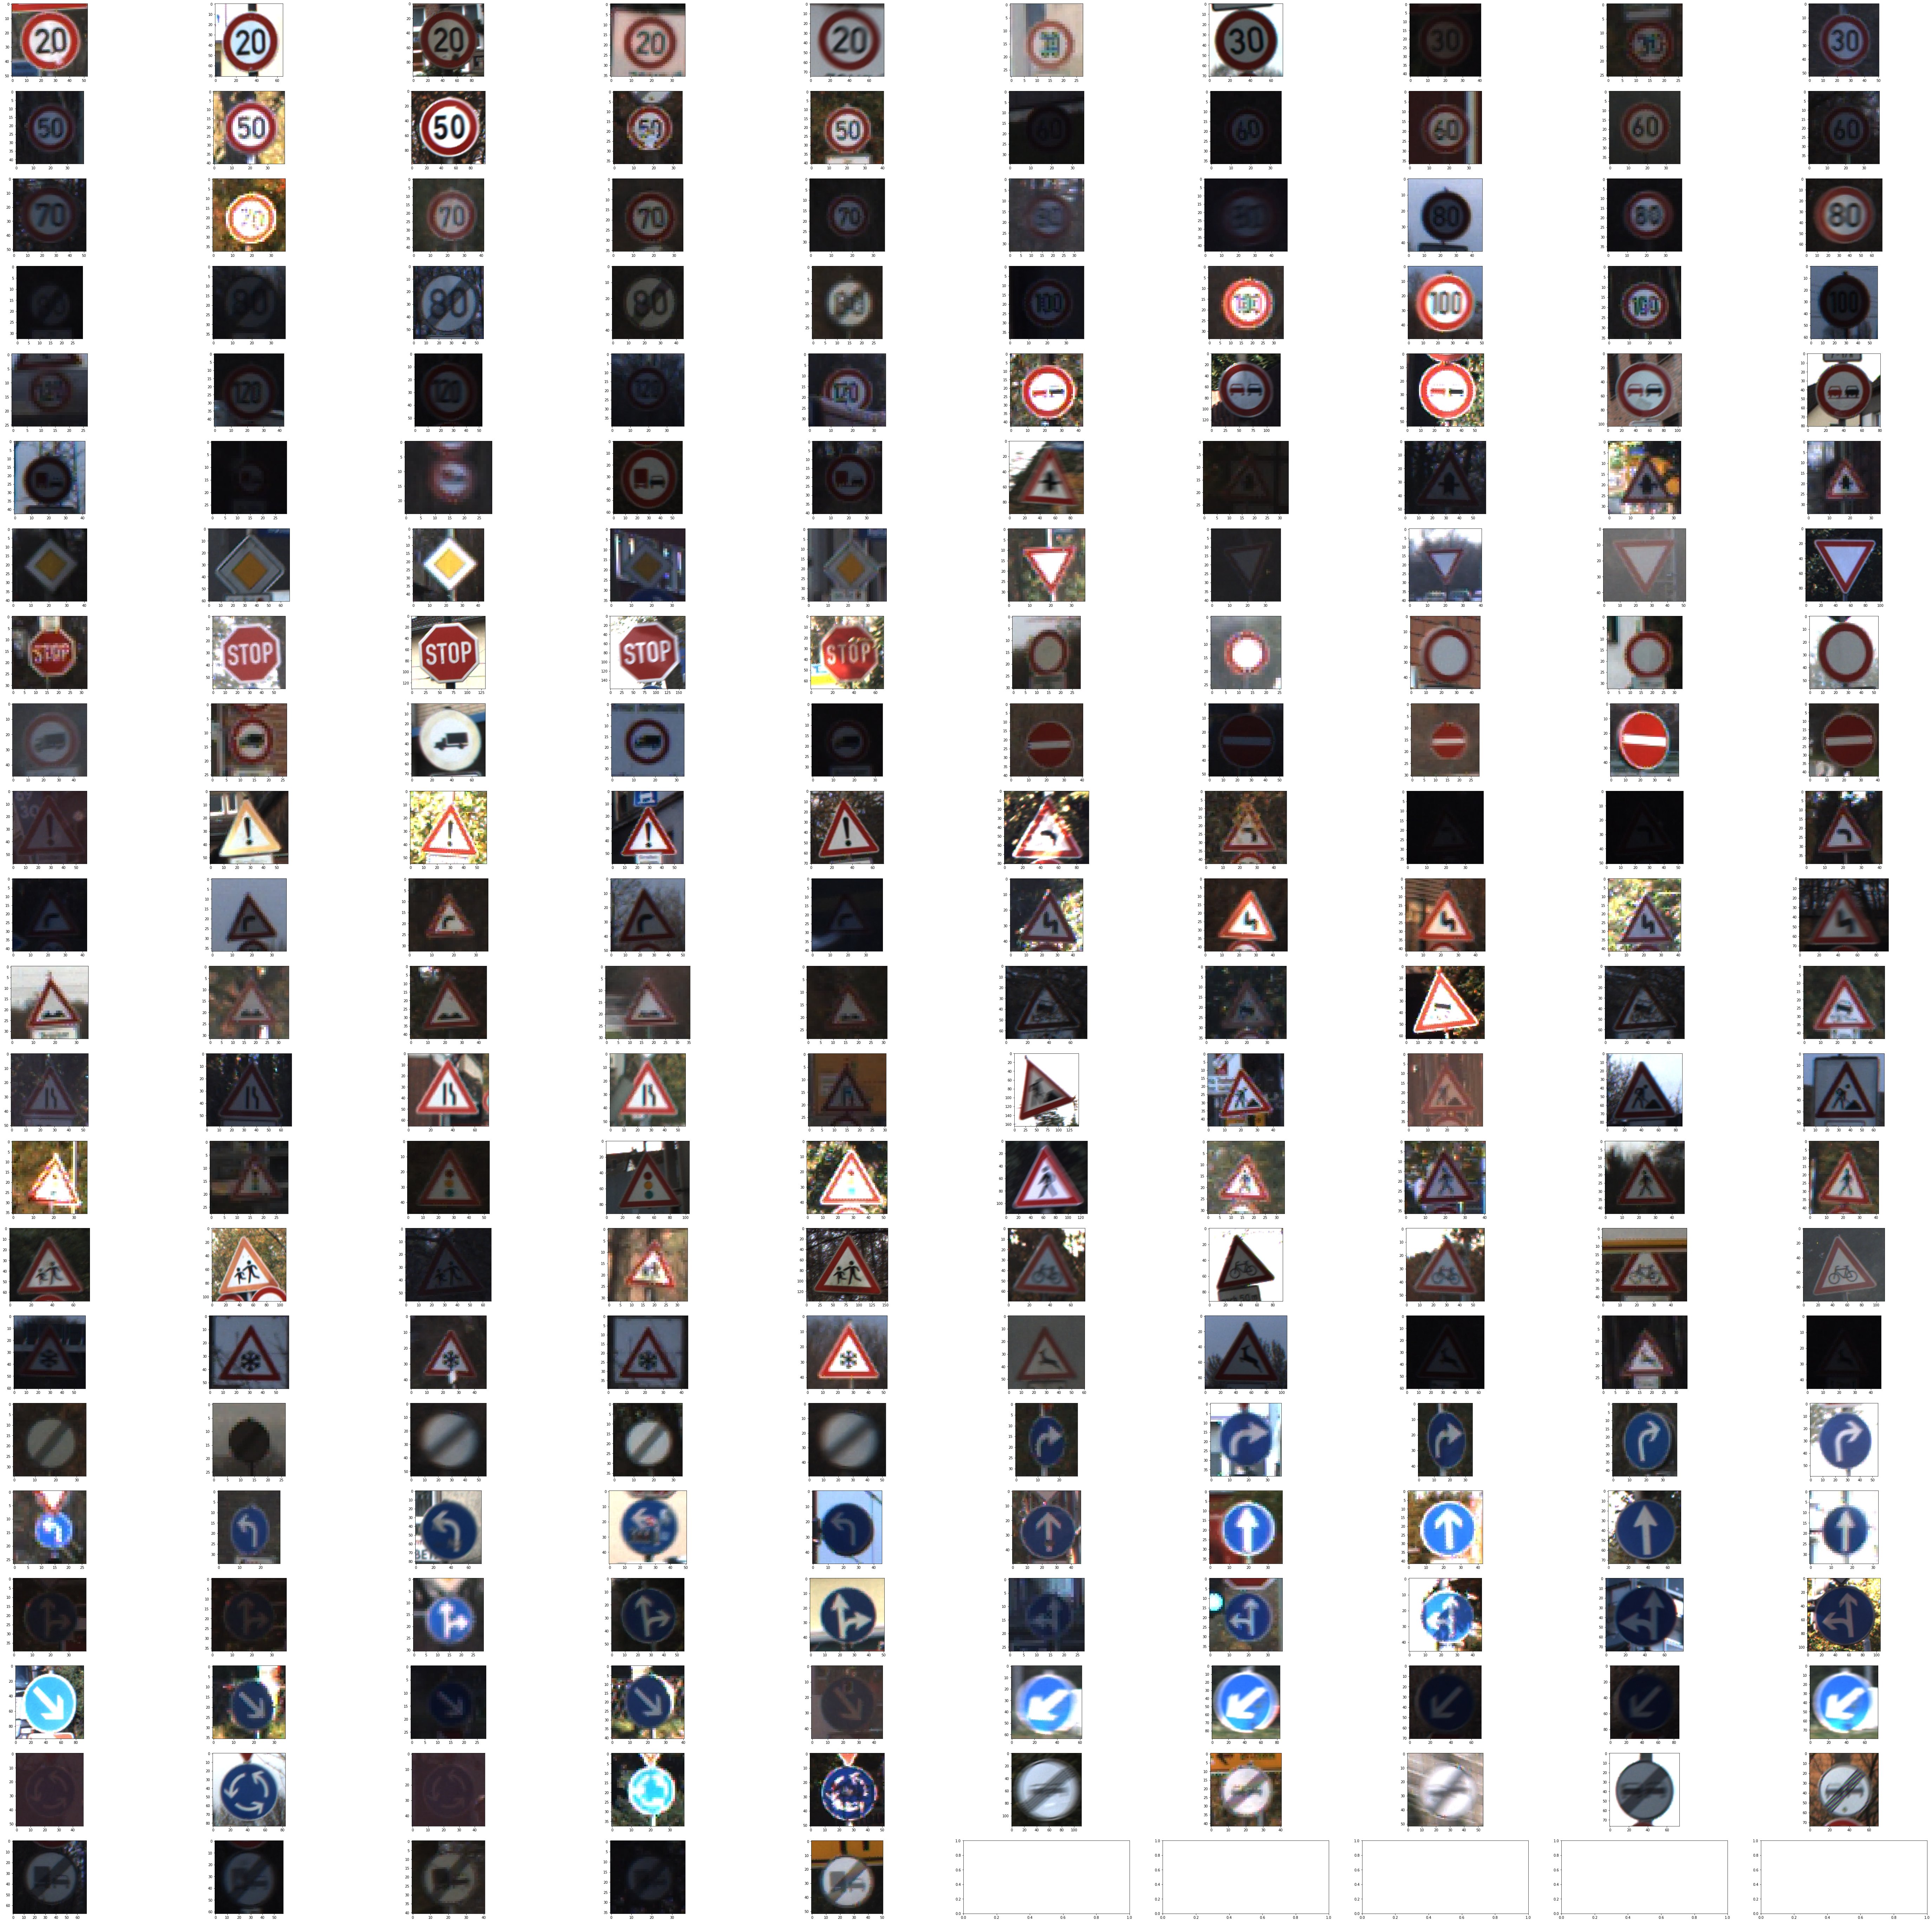

In [68]:
#view some images from the train data set and display them
numClasses = 43

fig, axs = plt.subplots(numClasses // 2 + 1, 10, figsize=(100,100))
#fig.tight_layout(h_pad = 20)

for i in range(numClasses):
    folderName = "./Train/" + str(i)

    
    filenames = os.listdir(folderName)
    random.shuffle(filenames)
    
    for j in range(5):
        imgName = folderName + "/" + filenames[j]
        img = Image.open(imgName)
        axs[i//2, j+(5*(i%2))].imshow(img)
        
 #   axs[row, col].set_title(str(i), fontsize=75)

plt.savefig("sample_train_images.png", dpi=40, bbox_inches = 'tight', pad_inches=0.5)

In [ ]:
# View the actual label and prediction of our model

# View the actual label and prediction of our model
 
 
# img.unsqueeze simply adds another dimension at the begining of the 1x1x112x112
# tensor, making it a 1x1x112x112 tensor, which the model views as a batch containing a single image.


##val_loader = data.DataLoader(val_data, shuffle=False, batch_size = BATCH_SIZE) ##without shuffle
##model = model.cuda()


#TRY to test one image
#images from val_loader
##images = next(iter(val_loader))
##print(len(images))
#print(images[0].size())
##print(images[1].size())
##print(images[1])


"""
for i in range(0,2):
  imageNum=i
  #print("image dim =",images[0][imageNum].size())
  

  myImageVal=images[0][imageNum] ; #image i

  #print(myImageVal.shape)

  plt.imshow(myImageVal.permute(1, 2, 0)  ) #convert from tensor
  print("image class =",images[1][imageNum])
  plt.figure()
"""  


"""
imageNum=17;
myImageVal=images[0][imageNum] ; #image i
plt.imshow(myImageVal.permute(1, 2, 0)  ) #convert from tensor
myImageVal=images[0][imageNum] ;
Myimage=myImageVal.unsqueeze(0)
print(Myimage.size())
print("image class =",images[1][imageNum])

output, _ = model(Myimage.cuda())

print(output.size())
print(output)
_,pred = torch.max(output,dim=1)
print(pred[0].item())
print("------")
print(pred)
print("------")
print("max=",output.max())
#print(output[1].min())

"""

# load  test set from test data set 

#Check if the prediction is correct.
#Use testdata

# test_data_arry[0]  --> #images
# test_data_arry[1]  --> #immageClassId
train_data2 = torchvision.datasets.ImageFolder(root = train_data_path, transform = data_transforms)
print(train_data2.class_to_idx)

indDic=list(train_data2.class_to_idx.keys());
print(indDic)
classId=list(train_data2.class_to_idx.values());
print(classId)


error=0;
for i in range(0,len(test_data_arry[0])):
 
  imageNum=i;
  myImageVal=test_data_arry[0][imageNum] ; #image i
  #plt.imshow(myImageVal.permute(1, 2, 0)  ) #convert from tensor

  Myimage=myImageVal.unsqueeze(0)
  
  ##print(Myimage.size())

  ##what we will have in csv file and what we will see in the folders, if I open folder "imageClassinTestDB" will see this traffic sign ##
  #print("image class id =",test_data_arry[1][imageNum])
  imageClassinTestDB=test_data_arry[1][imageNum];
  #print("ImageClassID in test set=",imageClassinTestDB)



  ##get value predicted by the model.
  output, _ = model(Myimage.cuda())
  #print(output.size())
  #print(output)
  _,pred = torch.max(output,dim=1)
  modelPredictedImageClass=pred[0].item();

  #print("model prediction=",pred[0].item())
  #print("------")
  #print(pred)
  #print("------")
  #print("max=",output.max())


  modelPredicted=classId.index(pred[0].item());
  modelPredictedImageClass=indDic[modelPredicted];

  #print("modelPredictedImageClass",modelPredictedImageClass)
  
  if(modelPredictedImageClass == str(imageClassinTestDB)):
    print ("Prediction is correct for the image  ",i)
  else:
    print ("Prediction is wrong for the image  ",i)
    error=error+1;


    

print ("Total Number of errors=",error)

print ("Error percentage ="+str(error/len(test_data_arry[0])*100)+"%");




In [83]:
ImageClasses = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing veh over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicles',
            16:'Veh > 3.5 tons prohibited',
            17:'No entry',
            18:'General caution',
            19:'Dangerous curve left',
            20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
            31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',
            37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',
            41:'End of no passing',
            42:'End no passing veh > 3.5 tons' }

In [70]:
train_data2 = torchvision.datasets.ImageFolder(root = train_data_path, transform = data_transforms)
print(train_data2.class_to_idx)

indDic=list(train_data2.class_to_idx.keys());
print(indDic)
classId=list(train_data2.class_to_idx.values());
print(classId)

i=classId.index(10);

print(indDic[i])




{'0': 0, '1': 1, '10': 2, '11': 3, '12': 4, '13': 5, '14': 6, '15': 7, '16': 8, '17': 9, '18': 10, '19': 11, '2': 12, '20': 13, '21': 14, '22': 15, '23': 16, '24': 17, '25': 18, '26': 19, '27': 20, '28': 21, '29': 22, '3': 23, '30': 24, '31': 25, '32': 26, '33': 27, '34': 28, '35': 29, '36': 30, '37': 31, '38': 32, '39': 33, '4': 34, '40': 35, '41': 36, '42': 37, '5': 38, '6': 39, '7': 40, '8': 41, '9': 42}
['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '5', '6', '7', '8', '9']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]
18


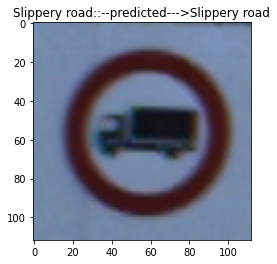

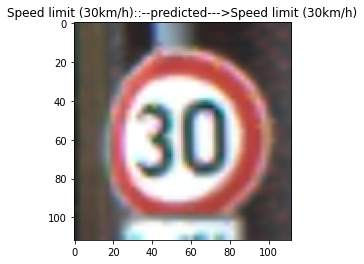

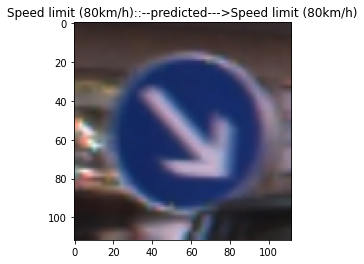

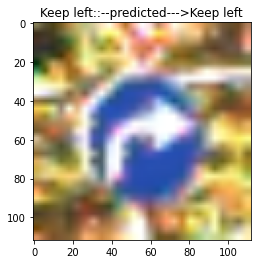

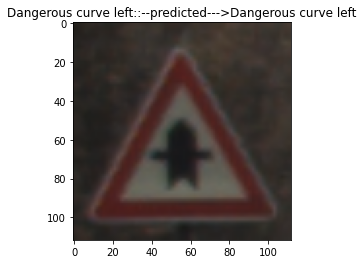

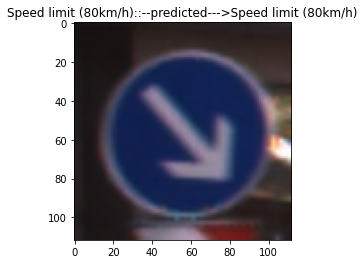

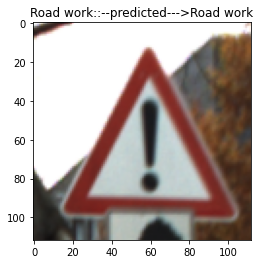

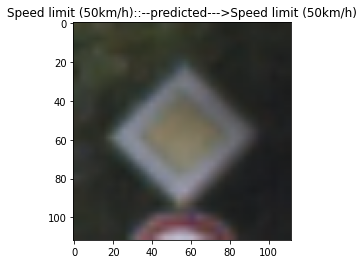

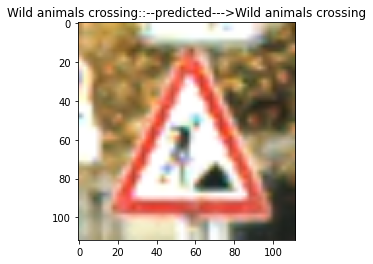

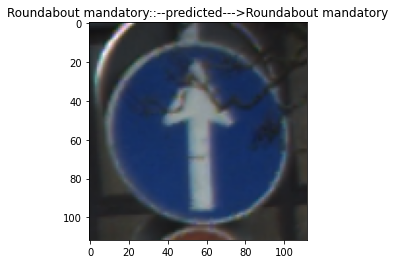

In [123]:
itrNum=10 # show inference for 10 random images from the test data set.
for i in range (0,itrNum):
    imageNum=i;
    myImageTensor=test_data_arry[0][imageNum] ; #image i
    myImage=myImageTensor.permute(1, 2, 0)   #convert from tensor

    label_item=test_data_arry[1][imageNum] ; #image i
    Images=myImageTensor.unsqueeze(0)
    output, _ = model(Images.cuda())


    ####Model prediction
    _,pred = torch.max(output,dim=1)
    modelPredictedImageClass=pred[0].item();
    #print(modelPredictedImageClass)
    modelPredicted=classId.index(pred[0].item());
    modelPredictedImageClass=indDic[modelPredicted];

    
    #print(modelPredictedImageClass)
    #print(label_item)
    #print("--")
    ##label from test data set
    if(int(modelPredictedImageClass)==label_item):
    #if(i==i): 
      ####Labels 
      
      labelImageClass=indDic[int(label_item)];
      LabelImageClass=ImageClasses[int(labelImageClass)]; 

      modelPredictedImageClass=indDic[int(modelPredictedImageClass)];
      modelPredictedImageClass=ImageClasses[int(modelPredictedImageClass)]; 


      imagePlot=Images.squeeze(0);
      plt.figure();
     
      title= str(LabelImageClass)+"::--predicted--->"+modelPredictedImageClass
      plt.title(title)
      plt.imshow(imagePlot.permute(1, 2, 0)  ) #convert from tensor
    
    else:
      print("error in prediction")

In [71]:
# Divide data into training and validation (0.8 and 0.2)
ratio = 0.5
n_train_examples = int(len(train_data) * ratio)
n_val_examples = len(train_data) - n_train_examples

train_attack_data, val_data = data.random_split(train_data, [n_train_examples, n_val_examples])

##split data for easier calculation in the attack, I don't want a lot of data(ratio*original data)
attack_train_loader=  data.DataLoader(train_attack_data, shuffle=True, batch_size = 1) #use one image per batch



Sources : 
1-https://pytorch.org/tutorials/beginner/fgsm_tutorial.html#


---
2-https://adversarial-ml-tutorial.org/adversarial_examples/



In [124]:
def pgd(model, X, y, epsilon, alpha, num_iter):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        output, _ = model(X)
        criterion = nn.CrossEntropyLoss()
        criterion = criterion.cpu()
        loss = criterion(output, labels)

        #loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + X.shape[0]*alpha*delta.grad.data).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()



In [125]:
def pgd_linf(model, X, y, epsilon, alpha, num_iter):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
         
        output,_=model(X+delta);
        
        loss = nn.CrossEntropyLoss()(output, y)
 
        loss.backward()
 
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

In [126]:
def pgd_linf_targ(model, X, y, epsilon, alpha, num_iter, y_targ):
    """ Construct targeted adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        yp,_ = model(X + delta)
        
        loss = (yp[:,y_targ] - yp.gather(1,y[:,None])[:,0]).sum()
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

In [127]:
def pgd_linf_targ2(model, X, y, epsilon, alpha, num_iter, y_targ):
    """ Construct targeted adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        yp,_ = model(X + delta)
        
        loss = 2*yp[:,y_targ].sum() - yp.sum()
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()


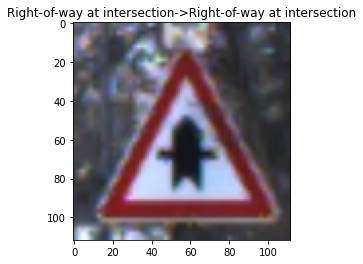

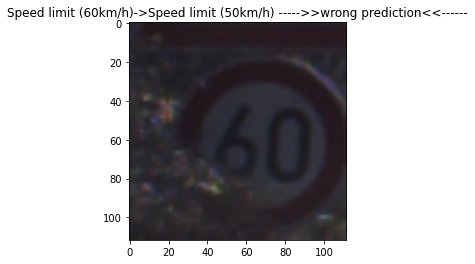

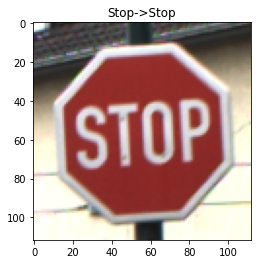

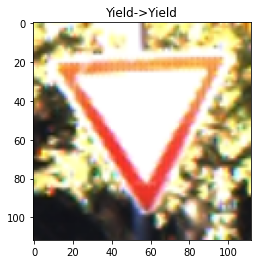

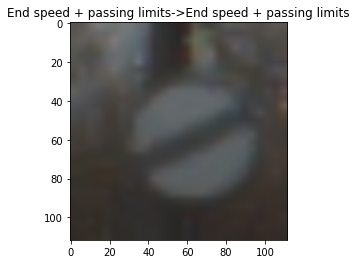

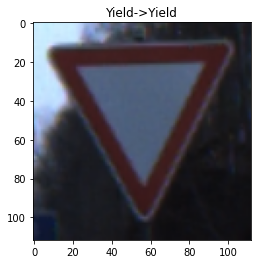

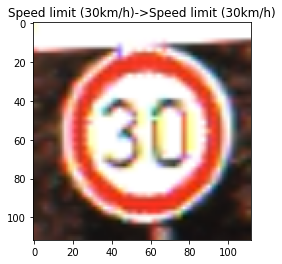

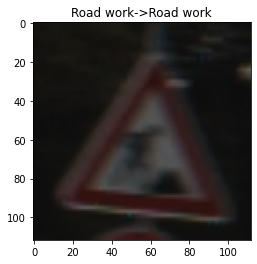

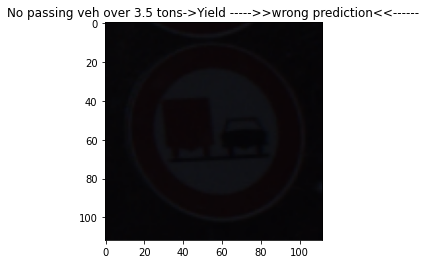

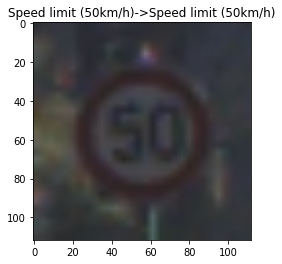

In [128]:
##attack using pgd_linf_targ2
itrNum=10;


for i in range (itrNum):
  Images,labels =next(iter(attack_train_loader))
  
  #delta = pgd_linf(model.cuda(), Images.cuda(), labels.cuda(), 0.1, 1e4, 1000)
 
  delta = pgd_linf_targ2(model.cuda(), Images.cuda(), labels.cuda(), 0.1, 1e4, 1000,int(labels.item()))
   
 

  ##get value predicted by the model.
  #output, _ = model(Images.cuda()+delta)
  output, _ = model(Images.cuda()+delta.cuda())

  _,pred = torch.max(output,dim=1)
  modelPredictedImageClass=pred[0].item();

  if(modelPredictedImageClass==labels.item()):
    
    
    ####Model prediction
    modelPredicted=classId.index(pred[0].item());
    modelPredictedImageClass=indDic[modelPredicted];
    modelPredictedImageClass=ImageClasses[int(modelPredictedImageClass)];

    ####Labels 
     
    labelImageClass=indDic[int(labels.item())];

    LabelImageClass=ImageClasses[int(labelImageClass)]; 

    imagePlot=Images.squeeze(0);
    plt.figure();
    title= str(LabelImageClass)+"->"+modelPredictedImageClass
    plt.title(title)
    plt.imshow(imagePlot.permute(1, 2, 0)  ) #convert from tensor
    title= str(LabelImageClass)+"->"+modelPredictedImageClass
    

  else:

    ####Model prediction
    modelPredicted=classId.index(pred[0].item());
    modelPredictedImageClass=indDic[modelPredicted];
    modelPredictedImageClass=ImageClasses[int(modelPredictedImageClass)];

    ####Labels 
     
    labelImageClass=indDic[int(labels.item())];

    LabelImageClass=ImageClasses[int(labelImageClass)]; 

    imagePlot=Images.squeeze(0);
    plt.figure();
    title= str(LabelImageClass)+"->"+modelPredictedImageClass
    

    plt.title(title+" ----->>wrong prediction<<------")
    plt.imshow(imagePlot.permute(1, 2, 0)  ) #convert from tensor

 

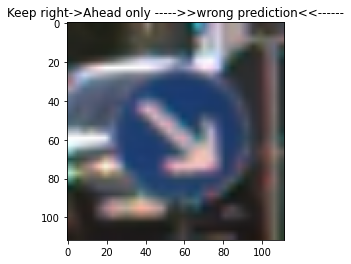

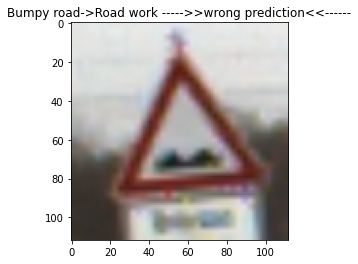

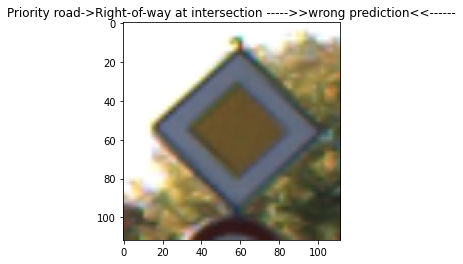

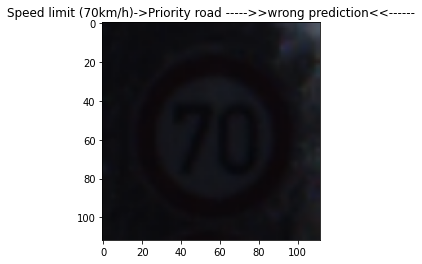

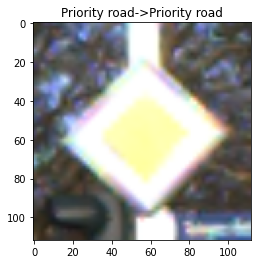

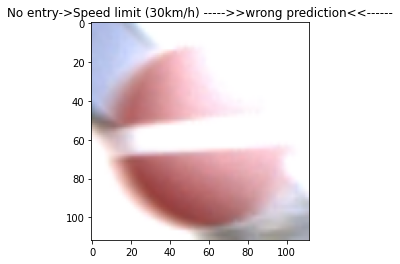

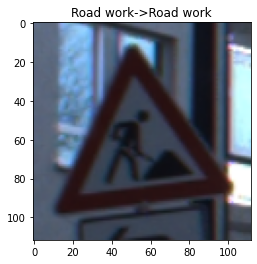

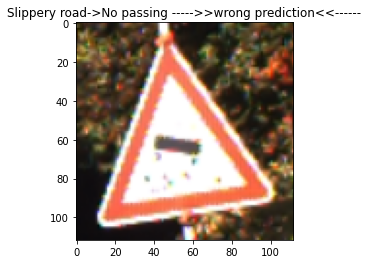

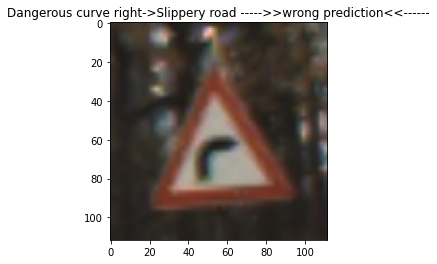

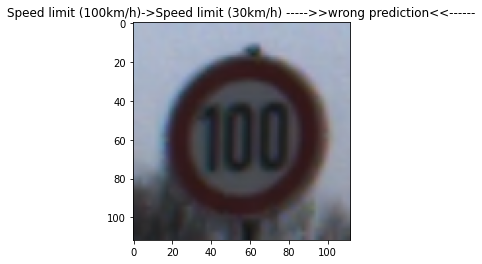

In [129]:
##attack using pgd_linf 
itrNum=10;


for i in range (itrNum):
  Images,labels =next(iter(attack_train_loader))
  
  delta = pgd_linf(model.cuda(), Images.cuda(), labels.cuda(), 0.1, 1e4, 1000)
 
  #delta = pgd_linf_targ2(model.cuda(), Images.cuda(), labels.cuda(), 0.1, 1e4, 1000,int(labels.item()))
   
 

  ##get value predicted by the model.
  #output, _ = model(Images.cuda()+delta)
  output, _ = model(Images.cuda()+delta.cuda())

  _,pred = torch.max(output,dim=1)
  modelPredictedImageClass=pred[0].item();

  if(modelPredictedImageClass==labels.item()):
    
    
    ####Model prediction
    modelPredicted=classId.index(pred[0].item());
    modelPredictedImageClass=indDic[modelPredicted];
    modelPredictedImageClass=ImageClasses[int(modelPredictedImageClass)];

    ####Labels 
     
    labelImageClass=indDic[int(labels.item())];

    LabelImageClass=ImageClasses[int(labelImageClass)]; 

    imagePlot=Images.squeeze(0);
    plt.figure();
    title= str(LabelImageClass)+"->"+modelPredictedImageClass
    plt.title(title)
    plt.imshow(imagePlot.permute(1, 2, 0)  ) #convert from tensor
    title= str(LabelImageClass)+"->"+modelPredictedImageClass
    

  else:

    ####Model prediction
    modelPredicted=classId.index(pred[0].item());
    modelPredictedImageClass=indDic[modelPredicted];
    modelPredictedImageClass=ImageClasses[int(modelPredictedImageClass)];

    ####Labels 
     
    labelImageClass=indDic[int(labels.item())];

    LabelImageClass=ImageClasses[int(labelImageClass)]; 

    imagePlot=Images.squeeze(0);
    plt.figure();
    title= str(LabelImageClass)+"->"+modelPredictedImageClass
    

    plt.title(title+" ----->>wrong prediction<<------")
    plt.imshow(imagePlot.permute(1, 2, 0)  ) #convert from tensor

 

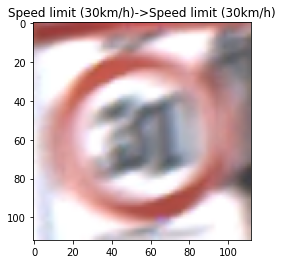

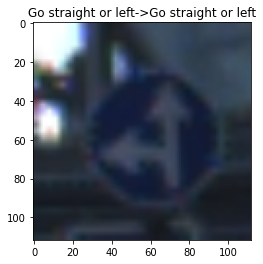

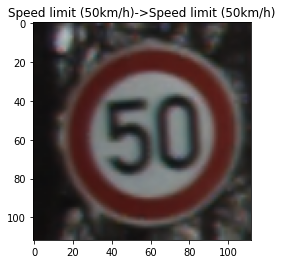

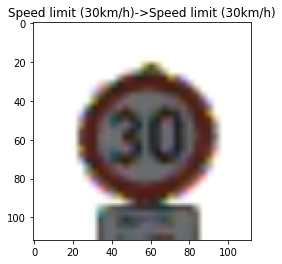

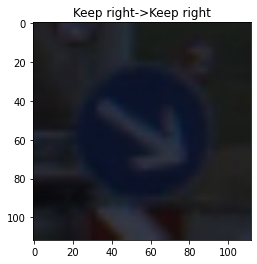

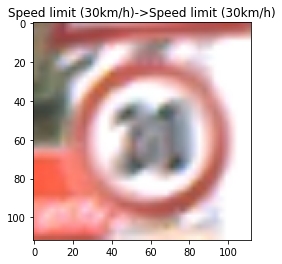

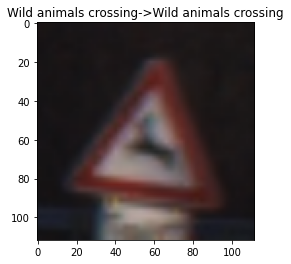

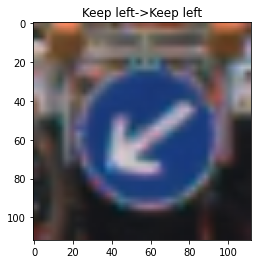

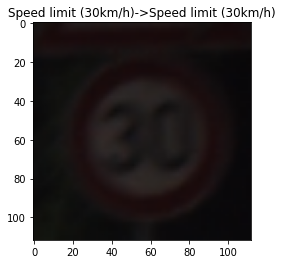

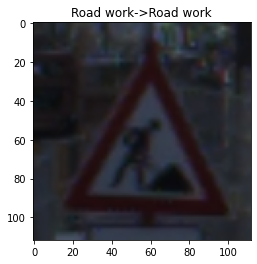

In [131]:
##attack using pgd_linf_targ
itrNum=10;


for i in range (itrNum):
  Images,labels =next(iter(attack_train_loader))
  
  #delta = pgd_linf(model.cuda(), Images.cuda(), labels.cuda(), 0.1, 1e4, 1000)
 
  delta = pgd_linf_targ(model.cuda(), Images.cuda(), labels.cuda(), 0.1, 1e4, 1000,int(labels.item()))
   
 

  ##get value predicted by the model.
  #output, _ = model(Images.cuda()+delta)
  output, _ = model(Images.cuda()+delta.cuda())

  _,pred = torch.max(output,dim=1)
  modelPredictedImageClass=pred[0].item();

  if(modelPredictedImageClass==labels.item()):
    
    
    ####Model prediction
    modelPredicted=classId.index(pred[0].item());
    modelPredictedImageClass=indDic[modelPredicted];
    modelPredictedImageClass=ImageClasses[int(modelPredictedImageClass)];

    ####Labels 
     
    labelImageClass=indDic[int(labels.item())];

    LabelImageClass=ImageClasses[int(labelImageClass)]; 

    imagePlot=Images.squeeze(0);
    plt.figure();
    title= str(LabelImageClass)+"->"+modelPredictedImageClass
    plt.title(title)
    plt.imshow(imagePlot.permute(1, 2, 0)  ) #convert from tensor
    title= str(LabelImageClass)+"->"+modelPredictedImageClass
    

  else:

    ####Model prediction
    modelPredicted=classId.index(pred[0].item());
    modelPredictedImageClass=indDic[modelPredicted];
    modelPredictedImageClass=ImageClasses[int(modelPredictedImageClass)];

    ####Labels 
     
    labelImageClass=indDic[int(labels.item())];

    LabelImageClass=ImageClasses[int(labelImageClass)]; 

    imagePlot=Images.squeeze(0);
    plt.figure();
    title= str(LabelImageClass)+"->"+modelPredictedImageClass
    

    plt.title(title+" ----->>wrong prediction<<------")
    plt.imshow(imagePlot.permute(1, 2, 0)  ) #convert from tensor

 

Source: https://github.com/surajmurthy/TSR_PyTorch/tree/main/Code
https://mailto-surajk.medium.com/a-tutorial-on-traffic-sign-classification-using-pytorch-dabc428909d7